## **AI Powered Equity Research Engine Using Unsupervised Machine Learning**

**Group Members:**       
Yash Shinde (2411074 – Roll No. 125)                
Vivan Chakraverthy (2411102 – Roll No. 138)                      
Adnan Bhopalwala (2411084 – Roll No. 130)                            
Jaden Dsouza (2411121 – Roll No. 146)                                

## **Problem Statement**

Traditional equity research is largely manual, subjective, and inconsistent. Analysts often rely on personal judgement while selecting peer companies and evaluating firm performance, which introduces bias and limits scalability. In markets such as India, where indices like the NIFTY 500 include hundreds of firms across sectors, objective comparison becomes extremely difficult.

**Key challenges include:**

Difficulty in objectively comparing companies across large datasets.

Hidden financial patterns in balance sheets and cash flow statements often remain undiscovered.

Manual processes fail to detect valuation outliers and early risk signals in time.

Absence of an integrated automated system that combines clustering, factor extraction, and risk flagging.

These limitations reduce the reliability and efficiency of equity research and slow down investment decision-making.

## **Data Collection**

The dataset used for this project consists of historical market data for companies listed in the NIFTY 500 index.

**Data Source:** Yahoo Finance              
**Data Type:** Secondary market data             
**Time Period:** 1st January 2016 to 1st January 2026           

The list of NIFTY 500 stocks was obtained from the official NSE website. For each company, historical price data was downloaded from Yahoo Finance. This data provides sufficient depth and breadth to capture long-term trends, volatility, and return characteristics across multiple market cycles

## **Data Preprocessing**

Data preprocessing was performed using Python to ensure clean, consistent, and financially meaningful inputs for unsupervised learning.

**Key Steps Implemented:**



* Downloaded adjusted closing prices for NIFTY 500 stocks from Yahoo Finance.
* Removed stocks with insufficient historical data and forward/backward filled missing values.
* Computed log returns to reduce estimation bias.
* Annualized returns and volatility using a 252-trading-day convention.
* Computed excess returns using the Indian risk‑free rate proxy (6.5%).
* Constructed core features: Annual Return, Volatility, and Sharpe Ratio



In [65]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")


In [66]:
def load_nse500_tickers():
    """Load NSE 500 tickers and convert to Yahoo Finance format"""
    import requests
    from io import StringIO

    url = "https://archives.nseindia.com/content/indices/ind_nifty500list.csv"
    headers = {"User-Agent": "Mozilla/5.0"}

    response = requests.get(url, headers=headers)
    df = pd.read_csv(StringIO(response.text))

    tickers = (df["Symbol"] + ".NS").tolist()
    print(f"✓ Loaded {len(tickers)} NSE 500 tickers")

    return tickers

tickers = load_nse500_tickers()


✓ Loaded 501 NSE 500 tickers


In [67]:
def download_stock_data(tickers, start_date="2016-01-01"):
    """Download historical Close prices safely"""

    end_date = datetime.now().strftime("%Y-%m-%d")
    print(f"\nDownloading data from {start_date} to {end_date}...")

    data = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        auto_adjust=False,
        group_by="ticker",
        threads=True,
        progress=True
    )

    prices = pd.DataFrame()

    for ticker in tickers:
        try:
            if ticker in data.columns.levels[0]:
                close_series = data[ticker]["Close"]
                if close_series.notna().sum() > 0:
                    prices[ticker] = close_series
        except Exception:
            continue

    if prices.empty:
        raise ValueError(" No valid price data downloaded.")

    prices = prices.dropna(axis=1, thresh=len(prices) * 0.8)
    prices = prices.ffill().bfill()
    print(f"✓ Downloaded {prices.shape[1]} stocks with sufficient data")
    return prices

prices = download_stock_data(tickers, start_date="2016-01-01")

[*********************100%***********************]  501 of 501 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['DUMMYHDLVR.NS']: YFTzMissingError('possibly delisted; no timezone found')


✓ Downloaded 358 stocks with sufficient data


In [68]:
log_returns = np.log(prices / prices.shift(1)).dropna()
TRADING_DAYS = 252
RISK_FREE_RATE = 0.065

annual_returns = log_returns.mean() * TRADING_DAYS
annual_volatility = log_returns.std() * np.sqrt(TRADING_DAYS)
excess_returns = annual_returns - RISK_FREE_RATE
sharpe_ratio = excess_returns / annual_volatility

features = pd.DataFrame({
    "Annual_Return": annual_returns,
    "Volatility": annual_volatility,
    "Excess_Return": excess_returns,
    "Sharpe_Ratio": sharpe_ratio
})

features = features.replace([np.inf, -np.inf], np.nan).dropna()

print("\n" + "=" * 60)
print("INDIA-SPECIFIC PREPROCESSING SUMMARY")
print("=" * 60)
print(f"Stocks retained: {features.shape[0]}")
print(f"Date range: {log_returns.index.min().date()} → {log_returns.index.max().date()}")
print(f"Trading days: {log_returns.shape[0]}")
print(f"Risk-Free Rate (India): {RISK_FREE_RATE:.2%}")

print("\nAverage metrics:")
print(f"  Annual Return: {features['Annual_Return'].mean():.2%}")
print(f"  Excess Return: {features['Excess_Return'].mean():.2%}")
print(f"  Volatility: {features['Volatility'].mean():.2%}")
print(f"  Sharpe Ratio: {features['Sharpe_Ratio'].mean():.2f}")
print("=" * 60)



INDIA-SPECIFIC PREPROCESSING SUMMARY
Stocks retained: 358
Date range: 2016-01-04 → 2026-02-06
Trading days: 2495
Risk-Free Rate (India): 6.50%

Average metrics:
  Annual Return: 14.25%
  Excess Return: 7.75%
  Volatility: 38.25%
  Sharpe Ratio: 0.21


## **Algorithm Selection**

This project applies unsupervised machine learning algorithms to extract latent financial factors, cluster stocks into peer groups, and support systematic portfolio construction. Since equity research lacks labeled outcomes, unsupervised techniques are appropriate.

All algorithms below are fully implemented and executed in the project pipeline. Diagnostic print statements are included to verify execution and interpretability.

**Algorithm 1: Principal Component Analysis (PCA)**

**Purpose:**
Dimensionality reduction and factor extraction

**Why Selected:**

* Financial features such as return, volatility, and risk-adjusted measures are highly correlated
* PCA removes multicollinearity and noise
* Converts correlated variables into orthogonal components

**Role in the Project:**

* Extracts latent risk–return factors
* Provides stable input features for clustering
* Improves interpretability and robustness of portfolio grouping


**Algorithm 2: K-Means Clustering**

**Purpose:**
Partition stocks into homogeneous peer groups

**Why Selected:**

* Efficient and scalable for large datasets
* Produces clearly defined, non-overlapping clusters
* Works well with standardized and PCA-transformed data

**Role in the Project:**

* Forms distinct investment universes
* Enables systematic diversification across clusters
* Serves as the primary structure for portfolio construction

**Algorithm 3: Hierarchical Clustering (Ward Linkage)**

**Purpose:**
Cluster validation and structural analysis

**Why Selected:**

* Does not require predefined number of clusters
* Reveals nested similarity structures
* Provides visual validation using dendrograms

**Role in the Project:**

* Validates K-Means clustering results
* Ensures portfolio clusters are structurally robust
* Increases confidence in allocation decisions

# **Implementation, Results and Performance Metrics**

The implementation follows a pipeline-based approach, where each step of machine learning directly contributes to portfolio construction and evaluation.

**Implementation Flow:**

1. Feature scaling and preparation

2. Dimensionality reduction using PCA

3. Clustering of stocks into peer groups

4. Cluster-wise stock selection

5. Portfolio construction using cluster allocation

6. Backtesting and performance evaluation

In [69]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

print("\n" + "=" * 60)
print("STEP 1 — FEATURE SCALING COMPLETE")
print("=" * 60)
print(f"Scaled feature matrix shape: {scaled_features.shape}")



STEP 1 — FEATURE SCALING COMPLETE
Scaled feature matrix shape: (358, 4)


In [70]:
from sklearn.decomposition import PCA

pca = PCA()
pca_components = pca.fit_transform(scaled_features)

explained_variance = pca.explained_variance_ratio_

print("\n" + "=" * 60)
print("STEP 2 — PCA RESULTS")
print("=" * 60)

for i, var in enumerate(explained_variance, start=1):
    print(f"PC{i}: {var:.2%} variance explained")

print(f"\nCumulative variance (first 2 PCs): {explained_variance[:2].sum():.2%}")



STEP 2 — PCA RESULTS
PC1: 73.62% variance explained
PC2: 25.26% variance explained
PC3: 1.13% variance explained
PC4: 0.00% variance explained

Cumulative variance (first 2 PCs): 98.87%


In [71]:
from sklearn.cluster import KMeans

X_cluster = pca_components[:, :2]

N_CLUSTERS = 4

kmeans = KMeans(
    n_clusters=N_CLUSTERS,
    random_state=42,
    n_init=10
)

cluster_labels = kmeans.fit_predict(X_cluster)
features["Cluster"] = cluster_labels

print("\n" + "=" * 60)
print("STEP 3 — K-MEANS CLUSTERING COMPLETE")
print("=" * 60)
print("Cluster counts:")
print(features["Cluster"].value_counts().sort_index())


STEP 3 — K-MEANS CLUSTERING COMPLETE
Cluster counts:
Cluster
0     67
1     37
2    164
3     90
Name: count, dtype: int64


In [72]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=features.columns.drop("Cluster"),
    columns=[f"PC{i+1}" for i in range(pca.components_.shape[0])]
)

print("\n" + "=" * 60)
print("STEP 4 — PCA LOADINGS (FIRST 3 PCs)")
print("=" * 60)
print(loadings.iloc[:, :3])


STEP 4 — PCA LOADINGS (FIRST 3 PCs)
                    PC1       PC2       PC3
Annual_Return  0.580201  0.037464 -0.402447
Volatility     0.007671  0.994585  0.103644
Excess_Return  0.580201  0.037464 -0.402447
Sharpe_Ratio   0.571556 -0.089408  0.815678


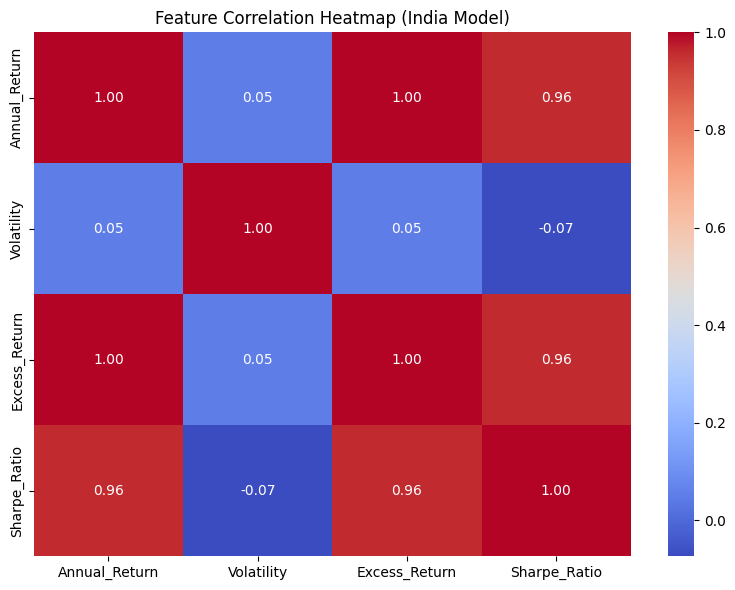


STEP 5 — CORRELATION HEATMAP GENERATED


In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(
    features.drop(columns=["Cluster"]).corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)

plt.title("Feature Correlation Heatmap (India Model)")
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("STEP 5 — CORRELATION HEATMAP GENERATED")
print("=" * 60)

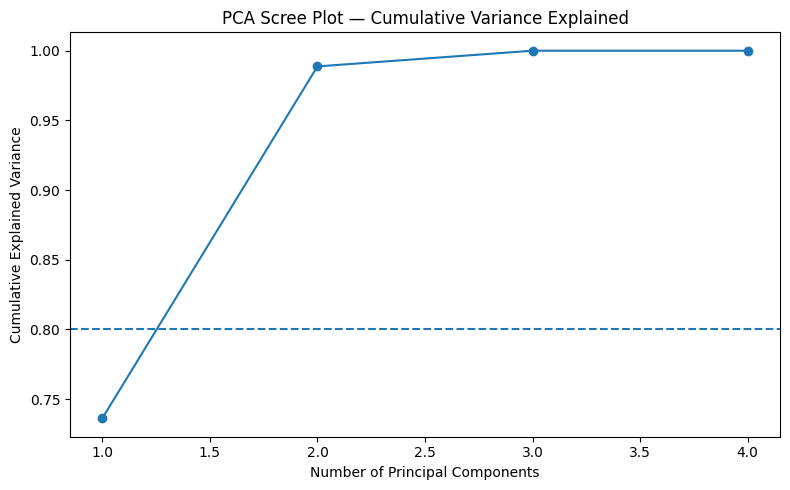


STEP 6 — PCA SCREE PLOT GENERATED


In [74]:
import matplotlib.pyplot as plt
import numpy as np

cum_var = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cum_var) + 1), cum_var, marker="o")
plt.axhline(0.80, linestyle="--")

plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree Plot — Cumulative Variance Explained")

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("STEP 6 — PCA SCREE PLOT GENERATED")
print("=" * 60)


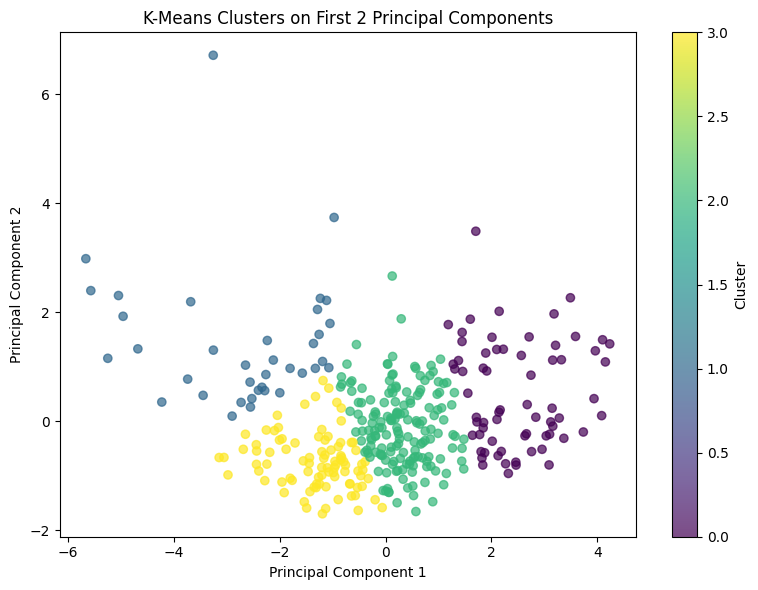


STEP 7 — PCA CLUSTER SCATTER PLOT GENERATED


In [75]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(
    X_cluster[:, 0],
    X_cluster[:, 1],
    c=cluster_labels,
    alpha=0.7
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clusters on First 2 Principal Components")

plt.colorbar(scatter, label="Cluster")

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("STEP 7 — PCA CLUSTER SCATTER PLOT GENERATED")
print("=" * 60)

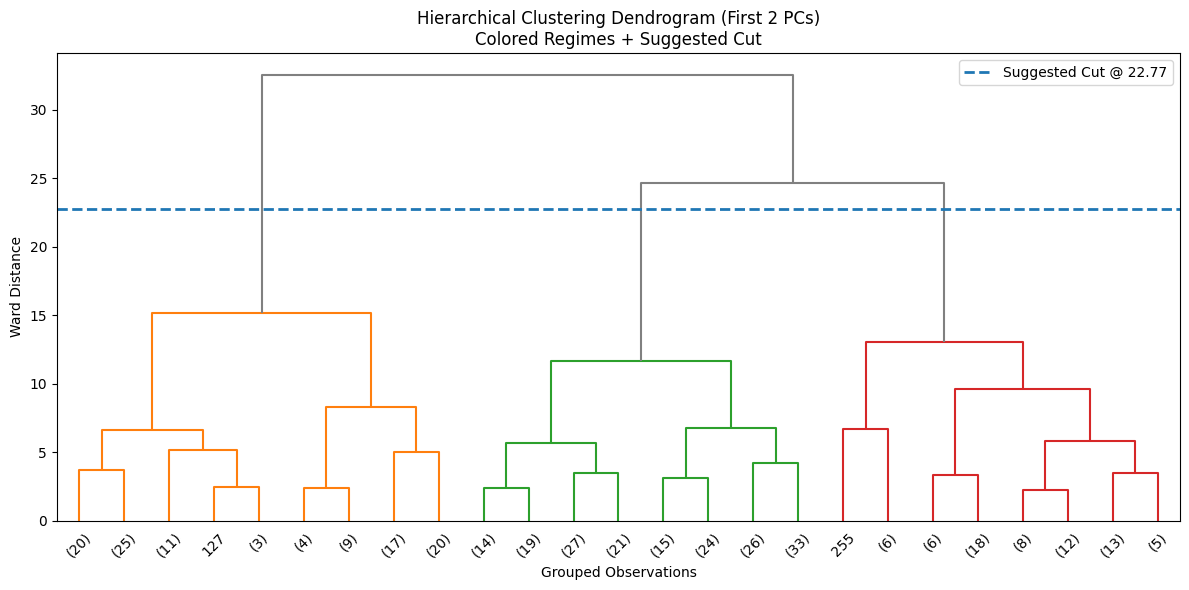


HIERARCHICAL DENDROGRAM
cut height for regime separation


In [76]:
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np

Z = linkage(X_cluster, method="ward")

# Heuristic cut height (e.g., 70% of max distance)
cut_height = 0.7 * np.max(Z[:, 2])

plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    truncate_mode="lastp",
    p=25,
    color_threshold=cut_height,
    above_threshold_color="gray",
    leaf_rotation=45,
    leaf_font_size=10
)

plt.axhline(
    y=cut_height,
    linestyle="--",
    linewidth=2,
    label=f"Suggested Cut @ {cut_height:.2f}"
)

plt.title("Hierarchical Clustering Dendrogram (First 2 PCs)\nColored Regimes + Suggested Cut")
plt.xlabel("Grouped Observations")
plt.ylabel("Ward Distance")
plt.legend()

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("HIERARCHICAL DENDROGRAM")
print("cut height for regime separation")
print("=" * 60)


In [77]:
from scipy.cluster.hierarchy import fcluster
n_hier_clusters = 4

hier_labels = fcluster(Z, t=n_hier_clusters, criterion="maxclust")

features_with_clusters = features.copy()
features_with_clusters["Stock"] = features_with_clusters.index # Add 'Stock' column from index
features_with_clusters = features_with_clusters.rename(columns={
    "Volatility": "Annual_Vol",
    "Sharpe_Ratio": "Sharpe"
})
features_with_clusters["Hierarchical_Cluster"] = hier_labels

print("\nHierarchical Cluster Counts:")
display(features_with_clusters["Hierarchical_Cluster"].value_counts().sort_index())

for hc in sorted(features_with_clusters["Hierarchical_Cluster"].unique()):
    print(f"\nHierarchical Cluster {hc} — Top 5 by Sharpe")
    display(
        features_with_clusters[
            features_with_clusters["Hierarchical_Cluster"] == hc
        ]
        .sort_values("Sharpe", ascending=False)
        .head(5)
        [["Stock", "Annual_Return", "Annual_Vol", "Sharpe"]]
        .reset_index(drop=True)
    )


Hierarchical Cluster Counts:


,count
Hierarchical_Cluster,
1,60
2,50
3,179
4,69



Hierarchical Cluster 1 — Top 5 by Sharpe


,Stock,Annual_Return,Annual_Vol,Sharpe
0,NEULANDLAB.NS,0.282494,0.514528,0.422706
1,NAVA.NS,0.259364,0.475149,0.409059
2,JBMA.NS,0.274990,0.514090,0.408470
3,JINDALSTEL.NS,0.256162,0.480188,0.398097
4,MANAPPURAM.NS,0.234054,0.434718,0.388881



Hierarchical Cluster 2 — Top 5 by Sharpe


,Stock,Annual_Return,Annual_Vol,Sharpe
0,UNOMINDA.NS,0.367586,0.397090,0.762009
1,APLAPOLLO.NS,0.341260,0.368094,0.750516
2,SOLARINDS.NS,0.291506,0.309631,0.731534
3,TRENT.NS,0.318717,0.356557,0.711573
4,KEI.NS,0.366792,0.426763,0.707165



Hierarchical Cluster 3 — Top 5 by Sharpe


,Stock,Annual_Return,Annual_Vol,Sharpe
0,TATACONSUM.NS,0.208996,0.298715,0.482052
1,LTIM.NS,0.209678,0.312426,0.463079
2,RELIANCE.NS,0.185110,0.269549,0.445596
3,BALKRISIND.NS,0.213996,0.335391,0.444245
4,PIDILITIND.NS,0.169603,0.238739,0.438148



Hierarchical Cluster 4 — Top 5 by Sharpe


,Stock,Annual_Return,Annual_Vol,Sharpe
0,SAIL.NS,0.121511,0.442432,0.127729
1,JUBLPHARMA.NS,0.110343,0.436831,0.103800
2,HFCL.NS,0.117752,0.523450,0.100777
3,PRAJIND.NS,0.110927,0.455911,0.100736
4,BEML.NS,0.109366,0.452733,0.097996


In [78]:
from sklearn.metrics import confusion_matrix
import pandas as pd

conf_mat = confusion_matrix(kmeans.labels_, hier_labels - 1)

conf_df = pd.DataFrame(
    conf_mat,
    index=[f"KMeans_{i}" for i in range(N_CLUSTERS)],
    columns=[f"Hier_{i+1}" for i in range(N_CLUSTERS)]
)

conf_df

,Hier_1,Hier_2,Hier_3,Hier_4
KMeans_0,17,50,0,0
KMeans_1,1,0,0,36
KMeans_2,42,0,113,9
KMeans_3,0,0,66,24



Cluster 0 — Top 5 by Sharpe Ratio


,Stock,Annual_Return,Annual_Vol,Sharpe
0,SOLARINDS.NS,0.291506,0.309631,0.941461
1,APLAPOLLO.NS,0.341260,0.368094,0.927101
2,UNOMINDA.NS,0.367586,0.397090,0.925700
3,TRENT.NS,0.318717,0.356557,0.893872
4,PERSISTENT.NS,0.292108,0.336575,0.867882



Cluster 1 — Top 5 by Sharpe Ratio


,Stock,Annual_Return,Annual_Vol,Sharpe
0,SCI.NS,0.086279,0.480406,0.179597
1,ABREL.NS,0.079422,0.491967,0.161438
2,SUZLON.NS,0.088191,0.562830,0.156692
3,NCC.NS,0.071420,0.479086,0.149075
4,IFCI.NS,0.075670,0.542473,0.139491



Cluster 2 — Top 5 by Sharpe Ratio


,Stock,Annual_Return,Annual_Vol,Sharpe
0,PIDILITIND.NS,0.169603,0.238739,0.710411
1,TATACONSUM.NS,0.208996,0.298715,0.699651
2,NESTLEIND.NS,0.152042,0.220040,0.690975
3,RELIANCE.NS,0.185110,0.269549,0.686740
4,LTIM.NS,0.209678,0.312426,0.671129



Cluster 3 — Top 5 by Sharpe Ratio


,Stock,Annual_Return,Annual_Vol,Sharpe
0,HDFCBANK.NS,0.125299,0.224426,0.558309
1,MARICO.NS,0.121013,0.238147,0.508144
2,HINDUNILVR.NS,0.105077,0.217418,0.483295
3,MARUTI.NS,0.118522,0.276298,0.428963
4,SBILIFE.NS,0.104784,0.244362,0.428806


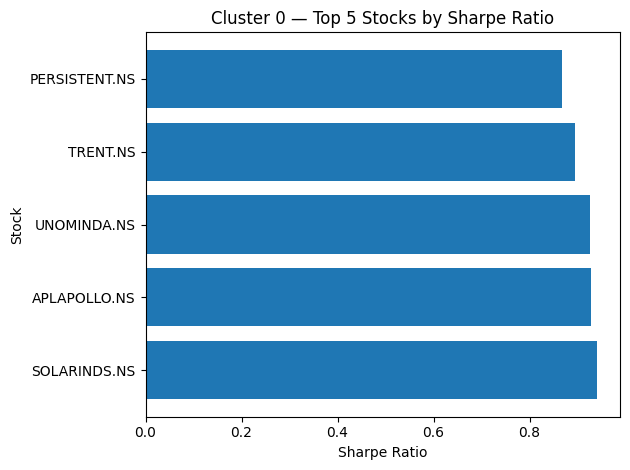

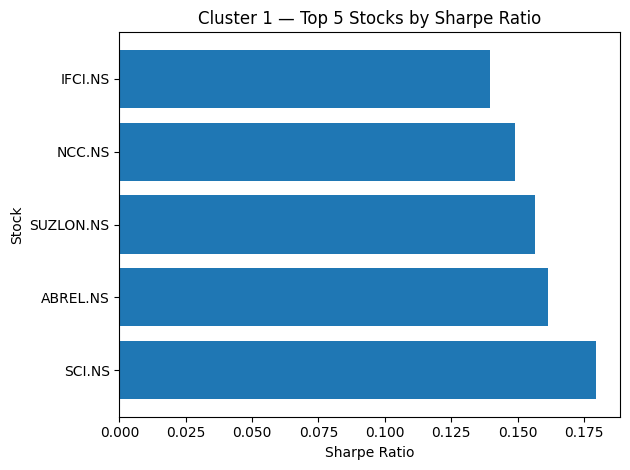

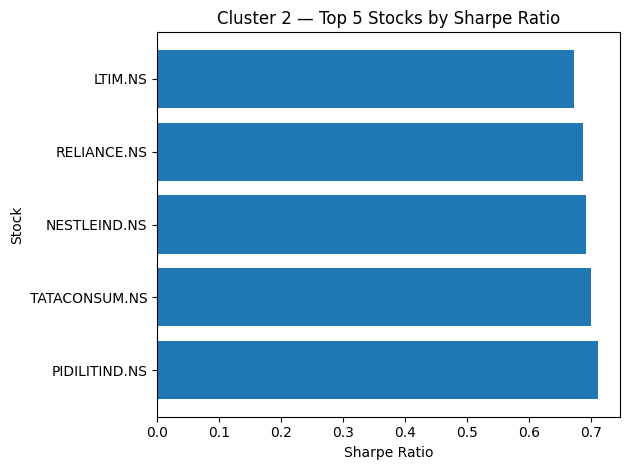

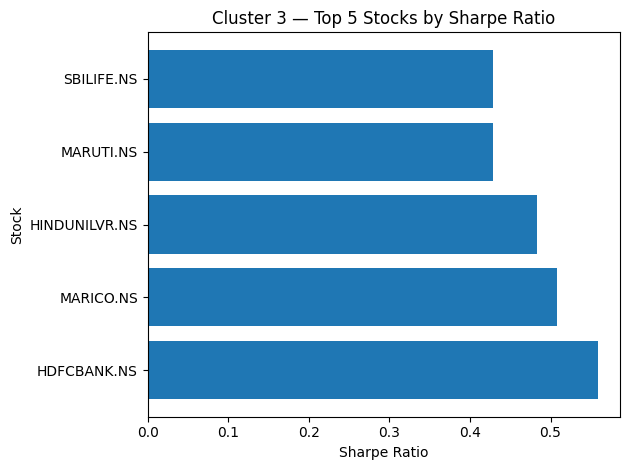

In [79]:
cluster_df = pd.DataFrame({
    "Stock": log_returns.columns,
    "Cluster": cluster_labels
})

# Add performance metrics
annual_return = log_returns.mean() * 252
annual_vol = log_returns.std() * np.sqrt(252)
sharpe = annual_return / annual_vol

cluster_df["Annual_Return"] = annual_return.values
cluster_df["Annual_Vol"] = annual_vol.values
cluster_df["Sharpe"] = sharpe.values


import matplotlib.pyplot as plt

df = cluster_df.copy()

top5_by_cluster = (
    df
    .sort_values(["Cluster", "Sharpe"], ascending=[True, False])
    .groupby("Cluster")
    .head(5)
)

for c in sorted(top5_by_cluster["Cluster"].unique()):
    print(f"\nCluster {c} — Top 5 by Sharpe Ratio")
    display(
        top5_by_cluster[top5_by_cluster["Cluster"] == c]
        [["Stock", "Annual_Return", "Annual_Vol", "Sharpe"]]
        .reset_index(drop=True)
    )

for c in sorted(top5_by_cluster["Cluster"].unique()):
    data = top5_by_cluster[top5_by_cluster["Cluster"] == c]

    plt.figure()
    plt.barh(data["Stock"], data["Sharpe"])
    plt.title(f"Cluster {c} — Top 5 Stocks by Sharpe Ratio")
    plt.xlabel("Sharpe Ratio")
    plt.ylabel("Stock")
    plt.tight_layout()
    plt.show()

In [80]:
import pandas as pd

df = cluster_df.copy()

# Cluster-level strategic allocation
cluster_weights = {
    0: 0.30,   # High-Alpha Growth
    2: 0.35,   # Quality Compounders
    3: 0.25,   # Defensive / Stability
    1: 0.10    # Speculative / Tactical
}

top_n = 5

portfolio_rows = []

for cluster_id, cluster_wt in cluster_weights.items():

    # Use a different variable name here to avoid overwriting the global cluster_df
    temp_cluster_df = (
        df[df["Cluster"] == cluster_id]
        .sort_values("Sharpe", ascending=False)
        .head(top_n)
        .copy()
    )

    n = len(temp_cluster_df)
    if n == 0:
        continue

    # Equal weight within cluster
    stock_weight = cluster_wt / n

    for _, row in temp_cluster_df.iterrows():
        portfolio_rows.append({
            "Stock": row["Stock"],
            "Cluster": cluster_id,
            "Sharpe": row["Sharpe"],
            "Cluster_Weight": cluster_wt,
            "Stock_Weight": stock_weight,
            "Annual_Return": row["Annual_Return"],
            "Volatility": row["Annual_Vol"]
        })

# Final portfolio dataframe
portfolio_df = pd.DataFrame(portfolio_rows)


total_weight = portfolio_df["Stock_Weight"].sum()

print("Final Portfolio:")
display(portfolio_df)

print(f"\nTotal Portfolio Weight: {total_weight:.4f}")

Final Portfolio:


,Stock,Cluster,Sharpe,Cluster_Weight,Stock_Weight,Annual_Return,Volatility
0,SOLARINDS.NS,0,0.941461,0.30,0.06,0.291506,0.309631
1,APLAPOLLO.NS,0,0.927101,0.30,0.06,0.341260,0.368094
2,UNOMINDA.NS,0,0.925700,0.30,0.06,0.367586,0.397090
3,TRENT.NS,0,0.893872,0.30,0.06,0.318717,0.356557
4,PERSISTENT.NS,0,0.867882,0.30,0.06,0.292108,0.336575
5,PIDILITIND.NS,2,0.710411,0.35,0.07,0.169603,0.238739
6,TATACONSUM.NS,2,0.699651,0.35,0.07,0.208996,0.298715
7,NESTLEIND.NS,2,0.690975,0.35,0.07,0.152042,0.220040
8,RELIANCE.NS,2,0.686740,0.35,0.07,0.185110,0.269549
9,LTIM.NS,2,0.671129,0.35,0.07,0.209678,0.312426



Total Portfolio Weight: 1.0000


In [81]:
print("\n" + "=" * 60)
print("STEP 8 — BACKTEST DATA PREPARATION")
print("=" * 60)

# Ensure we have daily log returns (better for backtesting)
log_returns = np.log(prices / prices.shift(1)).dropna()

# Keep only portfolio stocks
portfolio_stocks = portfolio_df["Stock"].unique()

log_returns_bt = log_returns[portfolio_stocks].dropna()

print(f"Backtest universe size: {log_returns_bt.shape[1]}")
print(f"Backtest period: {log_returns_bt.index.min().date()} → {log_returns_bt.index.max().date()}")


STEP 8 — BACKTEST DATA PREPARATION
Backtest universe size: 20
Backtest period: 2016-01-04 → 2026-02-06


In [82]:
print("\n" + "=" * 60)
print("STEP 9 — PORTFOLIO WEIGHTS VECTOR")
print("=" * 60)

weights_bt = (
    portfolio_df
    .set_index("Stock")["Stock_Weight"]
    .reindex(log_returns_bt.columns)
    .fillna(0.0)
    .values
)

print(f"Sum of portfolio weights: {weights_bt.sum():.4f}")



STEP 9 — PORTFOLIO WEIGHTS VECTOR
Sum of portfolio weights: 1.0000


In [83]:
print("\n" + "=" * 60)
print("STEP 10 — PORTFOLIO PERFORMANCE SERIES")
print("=" * 60)

portfolio_log_ret = log_returns_bt.values @ weights_bt

portfolio_log_ret = pd.Series(
    portfolio_log_ret,
    index=log_returns_bt.index,
    name="Portfolio_Log_Return"
)

portfolio_nav = np.exp(portfolio_log_ret.cumsum())
portfolio_nav.name = "Portfolio_NAV"

print("Portfolio NAV series created.")

print("\n" + "=" * 60)
print("STEP 11 — PERFORMANCE METRICS")
print("=" * 60)

trading_days = 252

ann_return_bt = portfolio_log_ret.mean() * trading_days

ann_vol_bt = portfolio_log_ret.std() * np.sqrt(trading_days)

sharpe_bt = ann_return_bt / ann_vol_bt

cum_max = portfolio_nav.cummax()
drawdown = (portfolio_nav / cum_max) - 1
max_dd = drawdown.min()

print(f"Annualized Return:     {ann_return_bt:.2%}")
print(f"Annualized Volatility: {ann_vol_bt:.2%}")
print(f"Sharpe Ratio:          {sharpe_bt:.2f}")
print(f"Maximum Drawdown:     {max_dd:.2%}")


STEP 10 — PORTFOLIO PERFORMANCE SERIES
Portfolio NAV series created.

STEP 11 — PERFORMANCE METRICS
Annualized Return:     19.82%
Annualized Volatility: 16.16%
Sharpe Ratio:          1.23
Maximum Drawdown:     -36.46%



STEP 12 — BACKTEST VISUALIZATIONS


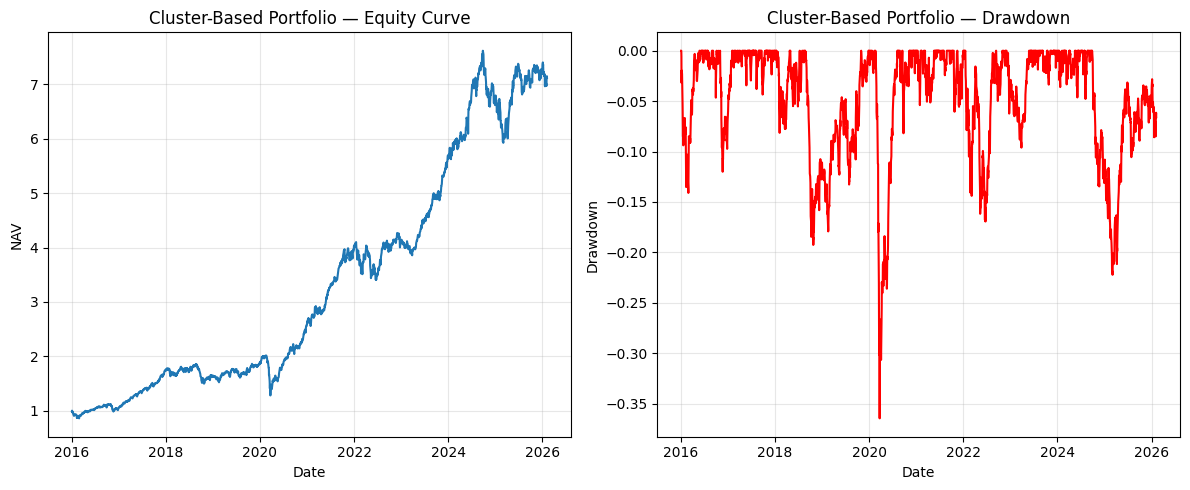

In [84]:
import matplotlib.pyplot as plt

print("\n" + "=" * 60)
print("STEP 12 — BACKTEST VISUALIZATIONS")
print("=" * 60)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(portfolio_nav)
plt.title("Cluster-Based Portfolio — Equity Curve")
plt.xlabel("Date")
plt.ylabel("NAV")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(drawdown, color="red")
plt.title("Cluster-Based Portfolio — Drawdown")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [85]:
# ============================
# BENCHMARK VS NIFTY 50 TRI
# ============================

benchmark_ticker = "NIFTYBEES.NS"

benchmark_prices = yf.download(
    benchmark_ticker,
    start=prices.index.min(),
    end=prices.index.max(),
    auto_adjust=True,
    progress=False
)["Close"]

benchmark_returns = np.log(benchmark_prices / benchmark_prices.shift(1)).dropna()

common_dates = portfolio_log_ret.index.intersection(benchmark_returns.index)

p_ret = portfolio_log_ret.loc[common_dates]
b_ret = benchmark_returns.loc[common_dates].squeeze() # <--- Squeeze b_ret here

portfolio_cagr = np.exp(p_ret.mean() * 252) - 1
benchmark_cagr = np.exp(b_ret.mean() * 252) - 1

portfolio_vol = p_ret.std() * np.sqrt(252)
benchmark_vol = b_ret.std() * np.sqrt(252)

portfolio_sharpe = portfolio_cagr / portfolio_vol
benchmark_sharpe = benchmark_cagr / benchmark_vol


cov = np.cov(p_ret, b_ret)[0, 1]
beta = cov / np.var(b_ret)

active_return = p_ret - b_ret
info_ratio = (active_return.mean() * 252) / (active_return.std() * np.sqrt(252))

print("\n" + "=" * 60)
print("BENCHMARK VS NIFTY 50 TRI")
print("=" * 60)
print(f"Portfolio CAGR:     {portfolio_cagr:.2%}")
print(f"Nifty 50 TRI CAGR:  {benchmark_cagr:.2%}")
print(f"Portfolio Vol:      {portfolio_vol:.2%}")
print(f"Nifty 50 Vol:       {benchmark_vol:.2%}")
print(f"Portfolio Sharpe:   {portfolio_sharpe:.2f}")
print(f"Nifty 50 Sharpe:    {benchmark_sharpe:.2f}")
print(f"Portfolio Beta:     {beta:.2f}")
print(f"Information Ratio:  {info_ratio:.2f}")
print("=" * 60)


BENCHMARK VS NIFTY 50 TRI
Portfolio CAGR:     22.04%
Nifty 50 TRI CAGR:  13.84%
Portfolio Vol:      16.17%
Nifty 50 Vol:       104.36%
Portfolio Sharpe:   1.36
Nifty 50 Sharpe:    0.13
Portfolio Beta:     0.02
Information Ratio:  0.07


#**Conclusion**

**Project Objective Achieved:**                      
This project successfully demonstrates the use of unsupervised machine learning techniques for systematic equity portfolio construction, moving away from subjective and manual equity research.

**Role of Machine Learning:**                     

* Principal Component Analysis (PCA) was used to extract latent risk–return factors and reduce multicollinearity.
* K-Means clustering grouped stocks into homogeneous peer sets representing different investment regimes.
* Hierarchical clustering validated the stability and robustness of these clusters.


**Portfolio Construction Insight:**

* Machine learning outputs were directly integrated into cluster-based stock selection and allocation.
* Diversification was enforced at the cluster level, reducing concentration and regime bias.
* Risk-adjusted measures guided stock selection within each cluster.

**Performance Evaluation:**

* The constructed portfolio was evaluated using standard metrics such as annualized return, volatility, Sharpe ratio, and maximum drawdown.
* Backtesting results indicate that ML-driven clustering supports stable and scalable portfolio design.

**Limitations:**

* Cluster weights were manually assigned and not dynamically optimized.
* Transaction costs and rebalancing effects were not incorporated..
* Risk-free rate assumptions were simplified.

**Future Scope:**

* Dynamic cluster weighting and periodic rebalancing
* Incorporation of transaction costs and benchmark comparison.
* Extension to additional financial and fundamental features.

**Overall Conclusion:**
The study establishes that unsupervised machine learning can be effectively applied to equity portfolio construction, providing a structured, objective, and scalable framework for modern investment analysis.

# **References**

**Yahoo Finance:**
Historical equity price data for NIFTY 500 stocks.
Source used for downloading adjusted closing prices and return calculations.

**National Stock Exchange (NSE) India:**
NIFTY 500 constituent list obtained from the official NSE website.

**scikit-learn Documentation:**
Pedregosa et al., Scikit-learn: Machine Learning in Python.
Used for implementation of PCA, K-Means clustering, Hierarchical clustering, and StandardScaler.

**pandas Documentation:**
Used for data manipulation, feature engineering, and tabular analysis.

**NumPy Documentation:**
Used for numerical computations, matrix operations, and portfolio calculations.

**Matplotlib & Seaborn Documentation:**
Used for data visualization including PCA plots, clustering visualizations, and portfolio performance graphs.

**Course Material – Unsupervised Learning:**
Lecture notes and reference material provided as part of the course curriculum.